In [1]:
%pylab inline
import numpy as np

# import torch

# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
#     print("running on the gpu")
# else:
#     device = torch.device("cpu")
#     print("running on the cpu")
    
from scDHA import scDHA

Populating the interactive namespace from numpy and matplotlib
running on the gpu


In [ ]:
path = "goolam"
do_clus = True
latent = scDHA(path, False, retrain=True, seed=1) # a list with 3 differently trained latent variables
print(len(latent), latent[0].shape)


## classification

In [ ]:
from Analysis import scDHA_class
res = scDHA_class('goolam', seed=1, retrain=False)

# Clustering

ari: 0.5448686870439825


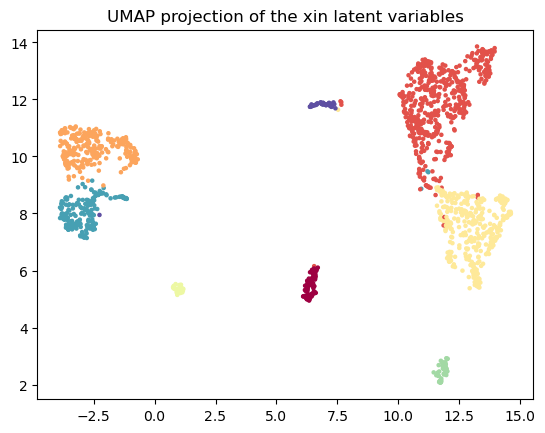

In [1]:
from Analysis import scDHA_vis, scDHA_clus
_, _ = scDHA_clus('xin', 8)
scDHA_vis('xin', 8)


test variation in xin

In [1]:
import scDHA_test
from Analysis import scDHA_class
from Analysis import scDHA_vis, scDHA_clus
import pandas as pd

In [2]:
cluster_num = {
    'yan': 6,
    'goolam': 5,
    'xin': 8,
    'kolodziejczyk': 3,
    'puram': 10,
}
result = pd.DataFrame([], columns=['norm', 'denoise_epochs',"encode_epochs", "lr", "wdecay", 'accuracy', 'ari', 'silhouette'])
def test_change(pathname: str,  norm='log', denoise_epochs=10, encode_epochs=[10, 20], lr=5e-4, wdecay = [1e-6, 1e-3]):
    global result
    for seed in range(1, 4):
        latent = scDHA_test.scDHA(pathname, False, norm=norm, denoise_epochs=denoise_epochs, encode_epochs=encode_epochs, lr=lr, wdecay = wdecay, seed=seed)
        _, accuracy = scDHA_class(pathname,latent=latent, seed=seed)
        best_latent, best_cluster, best_ari, best_silhouette = scDHA_clus(pathname, data=latent, n_clusters=cluster_num[pathname])
        scDHA_vis(pathname, best_latent=best_latent, best_cluster=best_cluster)
        result = pd.concat([result, pd.DataFrame.from_dict({'norm': [norm], 
                            'denoise_epochs': [denoise_epochs],
                            'encode_epochs':[encode_epochs[0]], 
                            'lr': [lr],
                            "wdecay": [wdecay[0]],
                            'accuracy':[accuracy], 
                            'ari': [best_ari], 
                            'silhouette':[best_silhouette]
                            })])
        # result = result.append({'norm': norm, 
        #                     'epochs':str(epochs), 
        #                     'accuracy':accuracy, 
        #                     'ari': best_ari, 
        #                     'silhouette':best_silhouette
        #                     }, ignore_index=True)
        
    

# analysis data

In [3]:
path = "xin"

norm

#################### log ########################
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.98
####################
ari: 0.5448686870439825
silhouette score: 0.1489444226026535


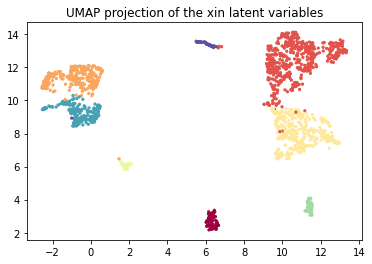

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5440635106228111
silhouette score: 0.15464435517787933


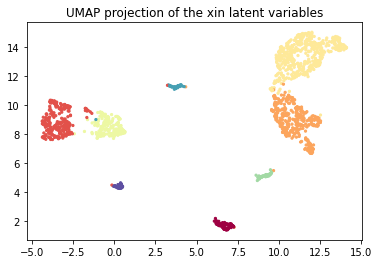

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.545833859229083
silhouette score: 0.15365873277187347


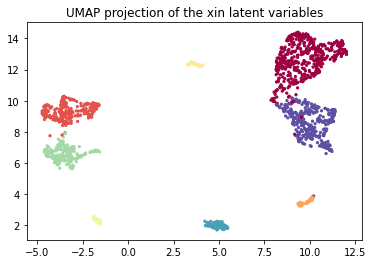

#################### l1 #######################
tensor([0.0837, 0.0808, 0.0746,  ..., 0.0807, 0.0957, 0.0835])

####################
    accuracy: 0.92
####################


E:\Anaconda\envs\py38\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


ari: 0.5094964525492087
silhouette score: 0.33081698417663574


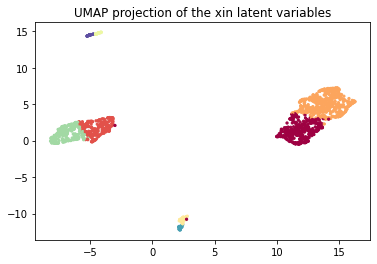

tensor([0.0520, 0.0539, 0.0452,  ..., 0.0505, 0.0619, 0.0488])

####################
    accuracy: 0.94
####################


E:\Anaconda\envs\py38\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


ari: 0.5186814806193565
silhouette score: 0.2834690809249878


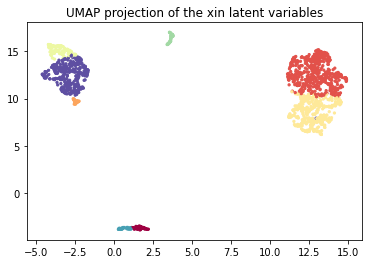

tensor([0.0642, 0.0648, 0.0581,  ..., 0.0621, 0.0644, 0.0644])

####################
    accuracy: 0.94
####################
ari: 0.482930738663665
silhouette score: 0.30975741147994995


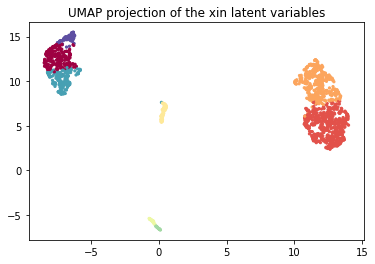

###################  l2 ########################
tensor([0.0837, 0.0808, 0.0746,  ..., 0.0807, 0.0957, 0.0835])

####################
    accuracy: 0.92
####################


E:\Anaconda\envs\py38\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


ari: 0.5094964525492087
silhouette score: 0.33081698417663574


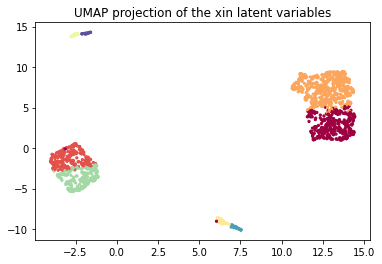

tensor([0.0520, 0.0539, 0.0452,  ..., 0.0505, 0.0619, 0.0488])

####################
    accuracy: 0.94
####################


E:\Anaconda\envs\py38\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


ari: 0.5186814806193565
silhouette score: 0.2834690809249878


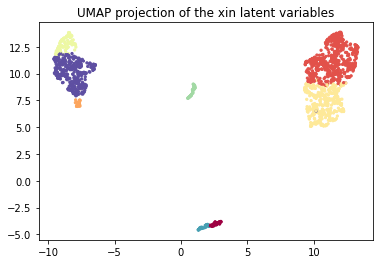

tensor([0.0642, 0.0648, 0.0581,  ..., 0.0621, 0.0644, 0.0644])

####################
    accuracy: 0.94
####################
ari: 0.482930738663665
silhouette score: 0.30975741147994995


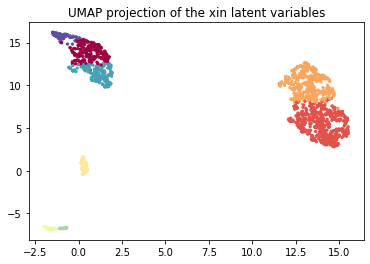

In [7]:
result = pd.DataFrame([], columns=['norm', 'denoise_epochs',"encode_epochs", "lr", "wdecay", 'accuracy', 'ari', 'silhouette'])
print("#################### log ########################")
test_change(path, norm='log')
print("#################### l1 #######################")
test_change(path, norm='l1')
print("###################  l2 ########################")
test_change(path, norm='l2')
result.to_csv(f'results/{path}_norm.csv', index=False)

encode epoch

############### epochs=5 ###########
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.97
####################
ari: 0.541582539960624
silhouette score: 0.15344412624835968


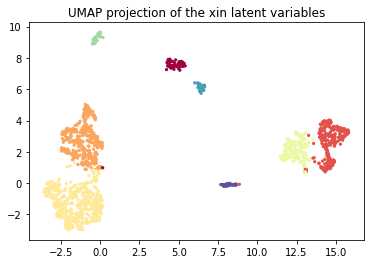

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5579562173000275
silhouette score: 0.15380612015724182


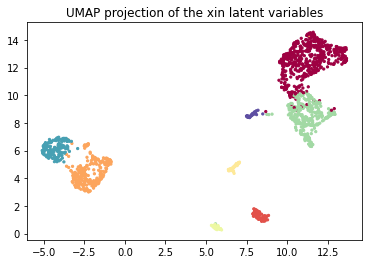

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5383572355994305
silhouette score: 0.15905442833900452


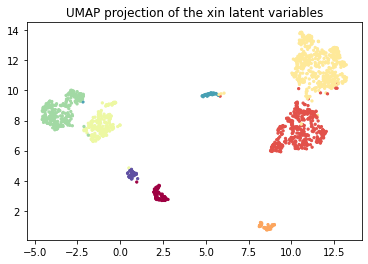

############### epochs=10 ###########
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.98
####################
ari: 0.5448686870439825
silhouette score: 0.1489444226026535


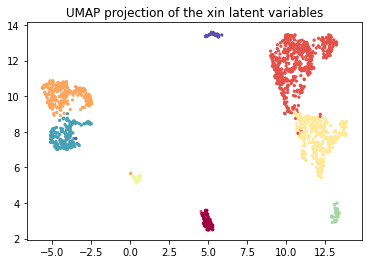

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5440635106228111
silhouette score: 0.15464435517787933


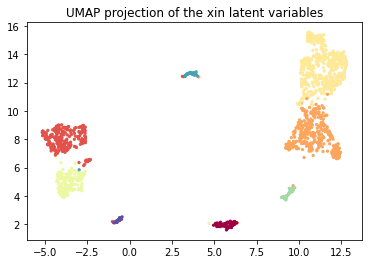

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.545833859229083
silhouette score: 0.15365873277187347


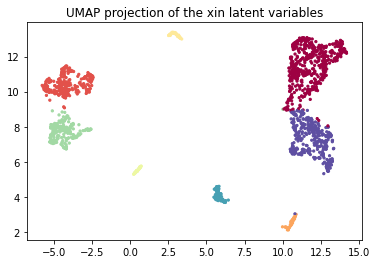

############### epochs=30 ###########
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.98
####################
ari: 0.5431069991563966
silhouette score: 0.15804661810398102


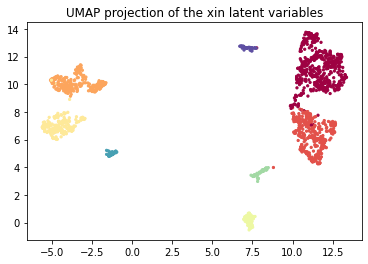

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5444654298422297
silhouette score: 0.1537085473537445


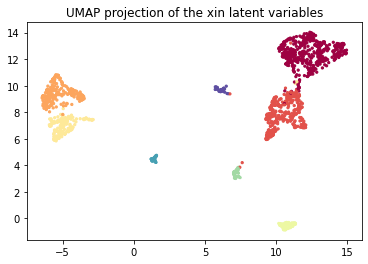

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5424865842382234
silhouette score: 0.1542758345603943


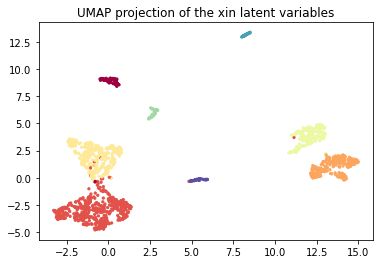

############### epochs=50 ###########
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.98
####################
ari: 0.5434134742365206
silhouette score: 0.1601153165102005


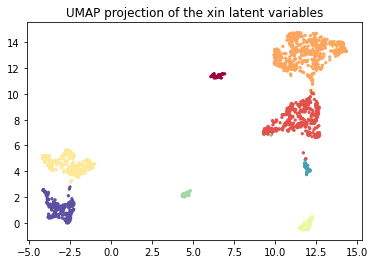

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5441666726182274
silhouette score: 0.15486040711402893


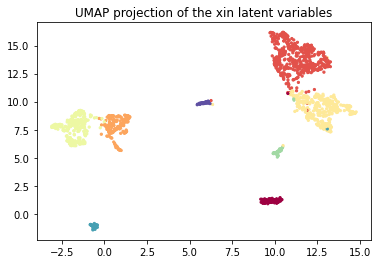

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5417884966320106
silhouette score: 0.1538161337375641


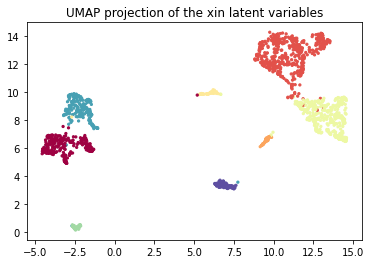

############### epochs=70 ###########
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.98
####################
ari: 0.5426781480095538
silhouette score: 0.15557923913002014


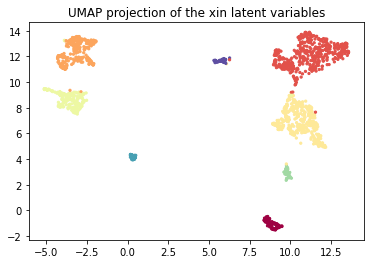

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5428125664020992
silhouette score: 0.15129265189170837


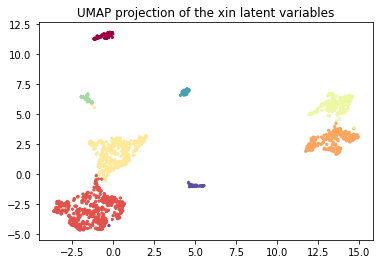

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5415323589312551
silhouette score: 0.1529291272163391


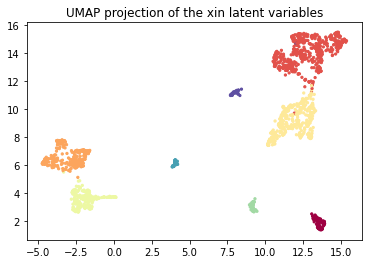

In [8]:
result = pd.DataFrame([], columns=['norm', 'denoise_epochs',"encode_epochs", "lr", "wdecay", 'accuracy', 'ari', 'silhouette'])
print("############### epochs=5 ###########")
test_change(path, encode_epochs=[5, 10])
print("############### epochs=10 ###########")
test_change(path, encode_epochs=[10, 20])
print("############### epochs=30 ###########")
test_change(path, encode_epochs=[30, 40])
print("############### epochs=50 ###########")
test_change(path, encode_epochs=[50, 60])
print("############### epochs=70 ###########")
test_change(path, encode_epochs=[70, 80])
result.to_csv(f'results/{path}_epochs.csv', index=False)

lr

######### lr=1e-4 #############
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.97
####################
ari: 0.520587869820663
silhouette score: 0.1626821905374527


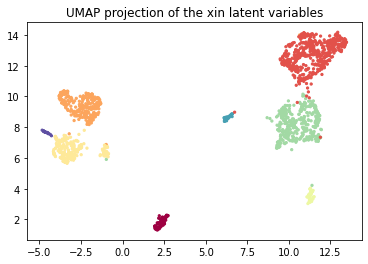

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.97
####################
ari: 0.5508781549004379
silhouette score: 0.1579160839319229


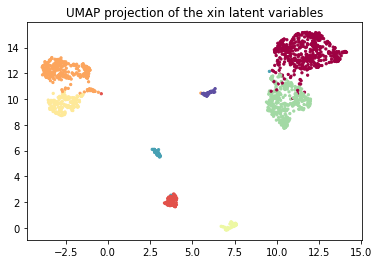

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5238916782203136
silhouette score: 0.16014118492603302


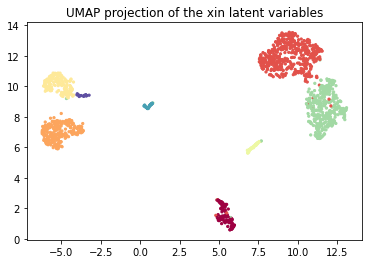

######### lr=3e-4 #############
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.98
####################
ari: 0.5425540698236662
silhouette score: 0.1528659611940384


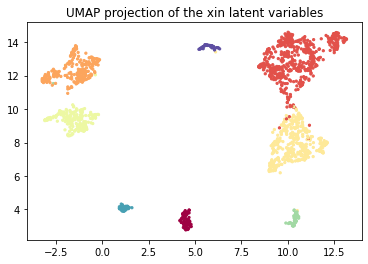

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5443602385817529
silhouette score: 0.14831510186195374


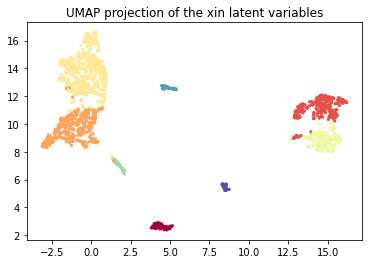

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5432526468496806
silhouette score: 0.14822831749916077


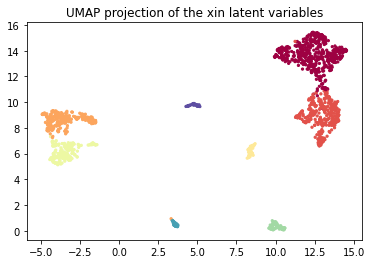

######### lr=5e-4 #############
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.98
####################
ari: 0.5431069991563966
silhouette score: 0.15804661810398102


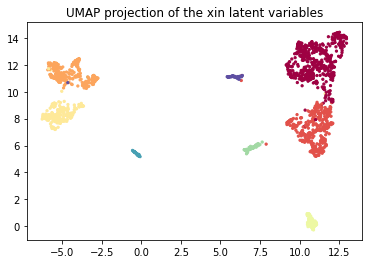

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5444654298422297
silhouette score: 0.1537085473537445


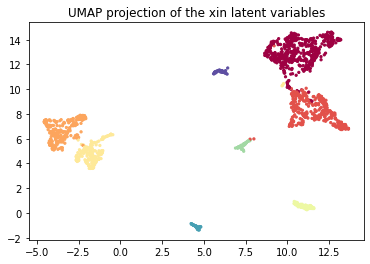

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5424865842382234
silhouette score: 0.1542758345603943


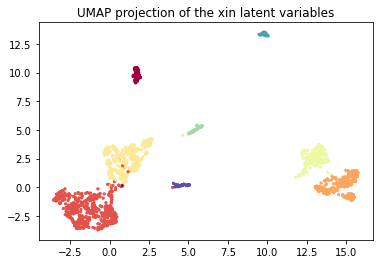

######### lr=7e-4 #############
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.97
####################
ari: 0.5418258726512403
silhouette score: 0.15617433190345764


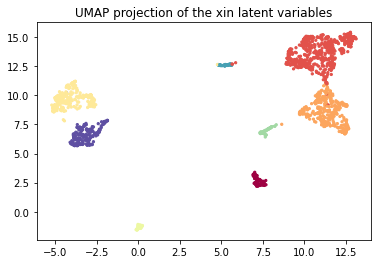

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.540740683834531
silhouette score: 0.15655815601348877


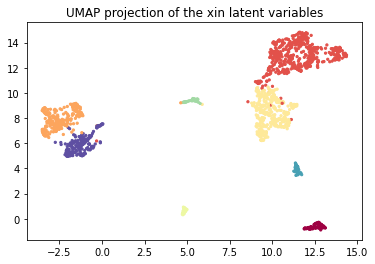

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5441450722315697
silhouette score: 0.15530113875865936


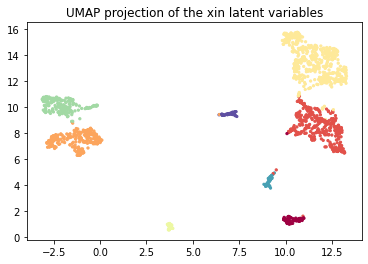

######### lr=1e-3 #############
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])

####################
    accuracy: 0.97
####################
ari: 0.5425075419608607
silhouette score: 0.15767867863178253


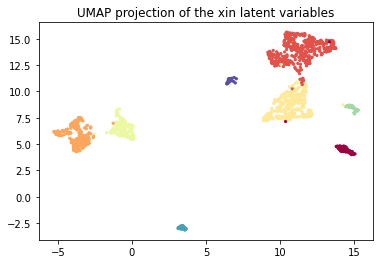

tensor([0.1040, 0.0978, 0.0542,  ..., 0.0562, 0.0621, 0.0677])

####################
    accuracy: 0.98
####################
ari: 0.5430604224709612
silhouette score: 0.1552426517009735


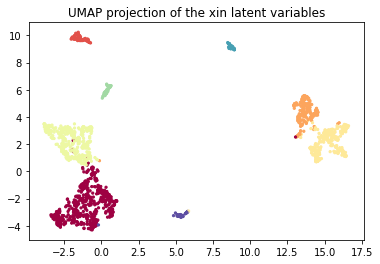

tensor([0.1022, 0.0976, 0.0562,  ..., 0.0561, 0.0574, 0.0707])

####################
    accuracy: 0.98
####################
ari: 0.5418564065242629
silhouette score: 0.15734699368476868


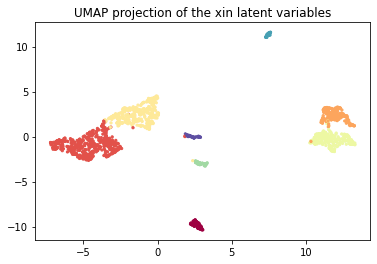

In [4]:
result = pd.DataFrame([], columns=['norm', 'denoise_epochs',"encode_epochs", "lr", "wdecay", 'accuracy', 'ari', 'silhouette'])
print("######### lr=1e-4 #############")
test_change(path, encode_epochs=[30, 40], lr=1e-4)
print("######### lr=3e-4 #############")
test_change(path, encode_epochs=[30, 40], lr=3e-4)
print("######### lr=5e-4 #############")
test_change(path, encode_epochs=[30, 40], lr=5e-4)
print("######### lr=7e-4 #############")
test_change(path, encode_epochs=[30, 40], lr=7e-4)
print("######### lr=1e-3 #############")
test_change(path, encode_epochs=[30, 40], lr=1e-3)
result.to_csv(f'results/{path}_lr.csv', index=False)

wdecay

In [5]:
result = pd.DataFrame([], columns=['norm', 'denoise_epochs',"encode_epochs", "lr", "wdecay", 'accuracy', 'ari', 'silhouette'])
print("############### 1e-8 #############")
test_change(path, wdecay = [1e-8, 1e-5])
print("############### 1e-7 #############")
test_change(path, wdecay = [1e-7, 1e-4])
print("############### 1e-6 #############")
test_change(path, wdecay = [1e-6, 1e-3])
print("############### 1e-5 #############")
test_change(path, wdecay = [1e-5, 1e-1])
result.to_csv(f'results/{path}_wdecay.csv', index=False)

############### 1e-8 #############
tensor([0.1046, 0.1093, 0.0551,  ..., 0.0575, 0.0650, 0.0753])


KeyboardInterrupt: 